In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import re
import pickle
import pandas as pd
import random
import csv
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from transformers import ( 
        RobertaTokenizer, 
        RoFormerModel,
        pipeline
    )

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

/home/yipingzou2/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### classification performance

covid_GSE247488, PRJNA890633, vaccination_GSE244297

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from scipy.stats import mannwhitneyu
import matplotlib.patches

# Define bootstrap functions
def bootstrap_mean_ci(data, n_bootstrap=10000, confidence=0.95):
    """Calculate bootstrap confidence intervals for median"""
    bootstrap_means = []
    n = len(data)
    
    np.random.seed(42)  # For reproducibility
    
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        bootstrap_means.append(np.mean(bootstrap_sample))
    
    alpha = 1 - confidence
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100
    
    ci_lower = np.percentile(bootstrap_means, lower_percentile)
    ci_upper = np.percentile(bootstrap_means, upper_percentile)
    
    return ci_lower, ci_upper

def get_significance_stars(p_value):
    """Convert p-value to significance stars"""
    if p_value <= 0.001:
        return "***"
    elif p_value <= 0.01:
        return "**"
    elif p_value <= 0.05:
        return "*"
    else:
        return "ns"

def add_significance_bracket(ax, x1, x2, y, p_value):
    """Add significance bracket to plot"""
    # Draw bracket
    ax.plot([x1, x1, x2, x2], [y, y+0.01, y+0.01, y], 'k-', linewidth=1)
    # Add significance stars
    ax.text((x1+x2)/2, y+0.015, get_significance_stars(p_value), 
            ha='center', va='bottom', fontsize=10, fontweight='bold')


uniBCR_clonotype_inner01_spike.csv: Median = 0.557, 95% CI = [0.547, 0.582]
antiberta2_spike.csv: Median = 0.431, 95% CI = [0.410, 0.456]
esm_spike.csv: Median = 0.358, 95% CI = [0.350, 0.375]
protT5_spike.csv: Median = 0.367, 95% CI = [0.348, 0.388]

Statistical Comparisons:
CoMBCR vs antiberta2: p-value = 0.0002 (***)
CoMBCR vs esm: p-value = 0.0002 (***)
CoMBCR vs protT5: p-value = 0.0002 (***)

SUMMARY TABLE
Method     Median   95% CI Lower 95% CI Upper p-value vs CoMBCR  Significance
--------------------------------------------------------------------------------
CoMBCR     0.557    0.547        0.582        -                  -           
AntiBERTa  0.431    0.410        0.456        0.0002             ***         
ESM        0.358    0.350        0.375        0.0002             ***         
ProtT5     0.367    0.348        0.388        0.0002             ***         


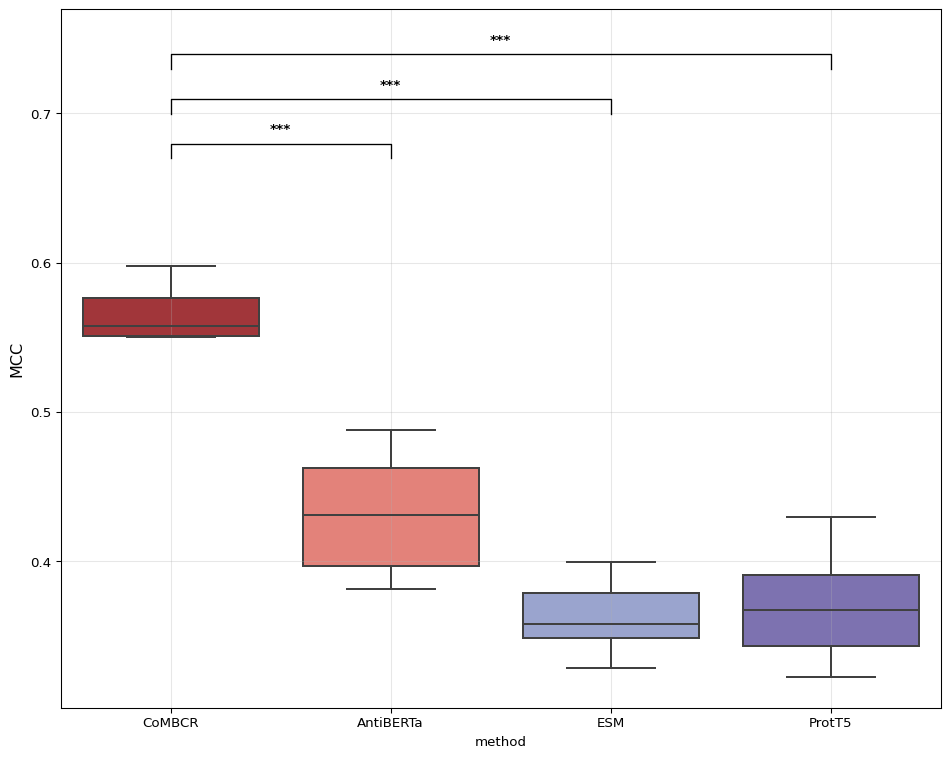

In [ ]:
# Define paths and files
resultpath = "/mnt/d/unifiedBCR/benchmark/assess/results/PRJNA890633"
resultfile = ['uniBCR_clonotype_inner01_spike.csv',
              'antiberta2_spike.csv',
              'esm_spike.csv', 
              'protT5_spike.csv']

results = []
medians = {}
confidence_intervals = {}
method_data = {}

# Process each file
for result in resultfile:
    metric = pd.read_csv(os.path.join(resultpath, result))[:10]
    
    # Extract method name
    if "CORR" in result.split('_')[0]:
        method_name = re.findall(r'(.*)CORR', result.split('_')[0])[0]
    else:
        method_name = result.split('_')[0]
    
    metric['method'] = method_name
    metric['condition'] = "norandom"  # Since we're only using non-random files
    
    # Store data for statistical testing
    method_data[method_name] = metric['MCC'].values
    
    # Calculate median and confidence interval
    median_value = metric['MCC'].median()
    medians[method_name] = median_value
    
    ci_lower, ci_upper = bootstrap_mean_ci(metric['MCC'].values)
    confidence_intervals[method_name] = (ci_lower, ci_upper)
    
    print(f"{result}: Median = {median_value:.3f}, 95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]")
    
    results.append(metric)

results = pd.concat(results, ignore_index=True)

# Statistical testing - compare all methods to uniBCR
methods = results['method'].unique()
method_labels = ["CoMBCR", "AntiBERTa", "ESM", "ProtT5"]
p_values = {}

combcr_data = method_data['uniBCR']

print("\nStatistical Comparisons:")
for method in methods:
    if method != 'uniBCR':
        statistic, p_value = mannwhitneyu(combcr_data, method_data[method], alternative='two-sided')
        p_values[method] = p_value
        print(f"CoMBCR vs {method}: p-value = {p_value:.4f} ({get_significance_stars(p_value)})")

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8), dpi=96)

# Define colors
my_colours = ['#B3242A', '#F47368', '#929FD6', '#7668BA']

# Create boxplot
sns.boxplot(data=results, x="method", y="MCC", ax=ax, 
            palette=my_colours, showfliers=False)
ax.set_xticklabels(method_labels)

# Add significance brackets
y_max = results['MCC'].max()
bracket_heights = [y_max + 0.05, y_max + 0.08, y_max + 0.11]

# Add brackets for significant comparisons
method_positions = {method: i for i, method in enumerate(methods)}
significant_comparisons = []

for method in methods:
    if method != 'uniBCR' and method in p_values:
        if get_significance_stars(p_values[method]) != "ns":
            significant_comparisons.append((0, method_positions[method], p_values[method]))

# Sort by distance to avoid overlapping brackets
significant_comparisons.sort(key=lambda x: x[1])

for i, (pos1, pos2, p_val) in enumerate(significant_comparisons):
    add_significance_bracket(ax, pos1, pos2, bracket_heights[i % len(bracket_heights)], p_val)

# Customize the plot
ax.set_ylabel('MCC', fontsize=12)
ax.grid(True, alpha=0.3)

# Adjust y-axis to accommodate brackets if there are significant comparisons
if significant_comparisons:
    ax.set_ylim(ax.get_ylim()[0], y_max + 0.15)

plt.tight_layout()

# Print summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(f"{'Method':<10} {'Median':<8} {'95% CI Lower':<12} {'95% CI Upper':<12} {'p-value vs CoMBCR':<18} {'Significance':<12}")
print("-"*80)

for method, label in zip(methods, method_labels):
    if method in medians and method in confidence_intervals:
        median_val = medians[method]
        ci_lower, ci_upper = confidence_intervals[method]
        
        if method == 'uniBCR':
            p_val_str = "-"
            sig_str = "-"
        else:
            p_val = p_values.get(method, np.nan)
            p_val_str = f"{p_val:.4f}" if not np.isnan(p_val) else "N/A"
            sig_str = get_significance_stars(p_val) if not np.isnan(p_val) else "N/A"
        
        print(f"{label:<10} {median_val:<8.3f} {ci_lower:<12.3f} {ci_upper:<12.3f} {p_val_str:<18} {sig_str:<12}")

plt.savefig("/mnt/d/unifiedBCR/figures/classification/PRJNA890633.pdf", 
            dpi=100, bbox_inches='tight')


uniBCR_clonotype_inner01new_spike.csv: Median = 0.583, 95% CI = [0.573, 0.597]
antiberta2_spike.csv: Median = 0.457, 95% CI = [0.439, 0.468]
esm_spike.csv: Median = 0.418, 95% CI = [0.412, 0.424]
protT5_spike.csv: Median = 0.418, 95% CI = [0.409, 0.440]

Statistical Comparisons:
CoMBCR vs antiberta2: p-value = 0.0002 (***)
CoMBCR vs esm: p-value = 0.0002 (***)
CoMBCR vs protT5: p-value = 0.0002 (***)

SUMMARY TABLE
Method     Median   95% CI Lower 95% CI Upper p-value vs CoMBCR  Significance
--------------------------------------------------------------------------------
CoMBCR     0.583    0.573        0.597        -                  -           
AntiBERTa  0.457    0.439        0.468        0.0002             ***         
ESM        0.418    0.412        0.424        0.0002             ***         
ProtT5     0.418    0.409        0.440        0.0002             ***         


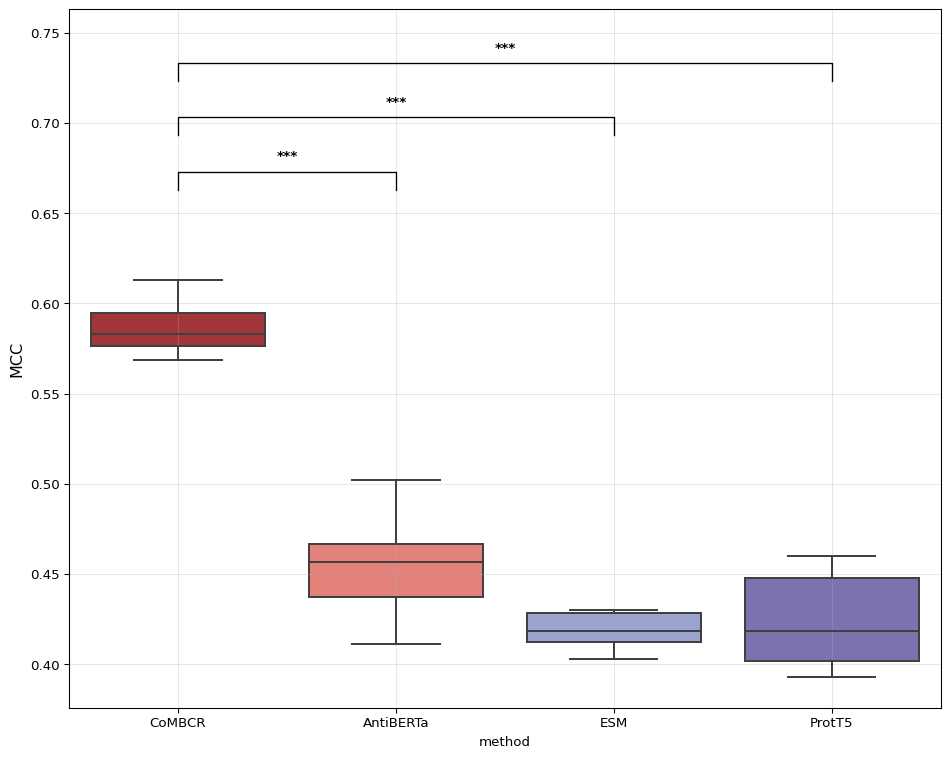

In [ ]:
# Define paths and files
resultpath = "/mnt/d/unifiedBCR/benchmark/assess/results/vaccination_GSE244297"
resultfile = ['uniBCR_clonotype_inner01new_spike.csv',
              'antiberta2_spike.csv',
              'esm_spike.csv', 
              'protT5_spike.csv']

results = []
medians = {}
confidence_intervals = {}
method_data = {}

# Process each file
for result in resultfile:
    metric = pd.read_csv(os.path.join(resultpath, result))[:10]
    
    # Extract method name
    if "CORR" in result.split('_')[0]:
        method_name = re.findall(r'(.*)CORR', result.split('_')[0])[0]
    else:
        method_name = result.split('_')[0]
    
    metric['method'] = method_name
    metric['condition'] = "norandom"  # Since we're only using non-random files
    
    # Store data for statistical testing
    method_data[method_name] = metric['MCC'].values
    
    # Calculate median and confidence interval
    median_value = metric['MCC'].median()
    medians[method_name] = median_value
    
    ci_lower, ci_upper = bootstrap_mean_ci(metric['MCC'].values)
    confidence_intervals[method_name] = (ci_lower, ci_upper)
    
    print(f"{result}: Median = {median_value:.3f}, 95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]")
    
    results.append(metric)

results = pd.concat(results, ignore_index=True)

# Statistical testing - compare all methods to uniBCR
methods = results['method'].unique()
method_labels = ["CoMBCR", "AntiBERTa", "ESM", "ProtT5"]
p_values = {}

combcr_data = method_data['uniBCR']

print("\nStatistical Comparisons:")
for method in methods:
    if method != 'uniBCR':
        statistic, p_value = mannwhitneyu(combcr_data, method_data[method], alternative='two-sided')
        p_values[method] = p_value
        print(f"CoMBCR vs {method}: p-value = {p_value:.4f} ({get_significance_stars(p_value)})")

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8), dpi=96)

# Define colors
my_colours = ['#B3242A', '#F47368', '#929FD6', '#7668BA']

# Create boxplot
sns.boxplot(data=results, x="method", y="MCC", ax=ax, 
            palette=my_colours, showfliers=False)
ax.set_xticklabels(method_labels)

# Add significance brackets
y_max = results['MCC'].max()
bracket_heights = [y_max + 0.05, y_max + 0.08, y_max + 0.11]

# Add brackets for significant comparisons
method_positions = {method: i for i, method in enumerate(methods)}
significant_comparisons = []

for method in methods:
    if method != 'uniBCR' and method in p_values:
        if get_significance_stars(p_values[method]) != "ns":
            significant_comparisons.append((0, method_positions[method], p_values[method]))

# Sort by distance to avoid overlapping brackets
significant_comparisons.sort(key=lambda x: x[1])

for i, (pos1, pos2, p_val) in enumerate(significant_comparisons):
    add_significance_bracket(ax, pos1, pos2, bracket_heights[i % len(bracket_heights)], p_val)

# Customize the plot
ax.set_ylabel('MCC', fontsize=12)
ax.grid(True, alpha=0.3)

# Adjust y-axis to accommodate brackets if there are significant comparisons
if significant_comparisons:
    ax.set_ylim(ax.get_ylim()[0], y_max + 0.15)

plt.tight_layout()

# Print summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(f"{'Method':<10} {'Median':<8} {'95% CI Lower':<12} {'95% CI Upper':<12} {'p-value vs CoMBCR':<18} {'Significance':<12}")
print("-"*80)

for method, label in zip(methods, method_labels):
    if method in medians and method in confidence_intervals:
        median_val = medians[method]
        ci_lower, ci_upper = confidence_intervals[method]
        
        if method == 'uniBCR':
            p_val_str = "-"
            sig_str = "-"
        else:
            p_val = p_values.get(method, np.nan)
            p_val_str = f"{p_val:.4f}" if not np.isnan(p_val) else "N/A"
            sig_str = get_significance_stars(p_val) if not np.isnan(p_val) else "N/A"
        
        print(f"{label:<10} {median_val:<8.3f} {ci_lower:<12.3f} {ci_upper:<12.3f} {p_val_str:<18} {sig_str:<12}")

plt.savefig("/mnt/d/unifiedBCR/figures/classification/vaccination_GSE244297.pdf", 
            dpi=100, bbox_inches='tight')


uniBCR_clonotype_inner01new_spike.csv: Median = 0.294, 95% CI = [0.255, 0.304]
antiberta2_spike.csv: Median = 0.191, 95% CI = [0.164, 0.213]
esm_spike.csv: Median = 0.150, 95% CI = [0.141, 0.170]
protT5_spike.csv: Median = 0.153, 95% CI = [0.138, 0.171]

Statistical Comparisons:
CoMBCR vs antiberta2: p-value = 0.0006 (***)
CoMBCR vs esm: p-value = 0.0002 (***)
CoMBCR vs protT5: p-value = 0.0002 (***)

SUMMARY TABLE
Method     Median   95% CI Lower 95% CI Upper p-value vs CoMBCR  Significance
--------------------------------------------------------------------------------
CoMBCR     0.294    0.255        0.304        -                  -           
AntiBERTa  0.191    0.164        0.213        0.0006             ***         
ESM        0.150    0.141        0.170        0.0002             ***         
ProtT5     0.153    0.138        0.171        0.0002             ***         


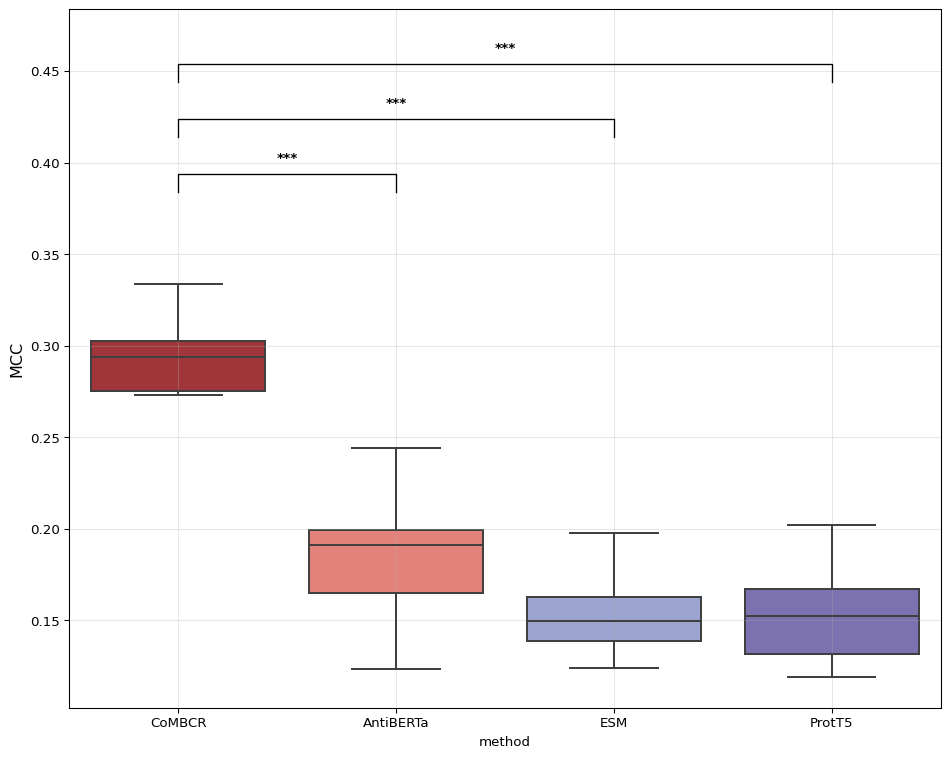

In [ ]:
# Define paths and files
resultpath = "/mnt/d/unifiedBCR/benchmark/assess/results/covid_GSE247488"
resultfile = ['uniBCR_clonotype_inner01new_spike.csv',
              'antiberta2_spike.csv',
              'esm_spike.csv', 
              'protT5_spike.csv']

results = []
medians = {}
confidence_intervals = {}
method_data = {}

# Process each file
for result in resultfile:
    metric = pd.read_csv(os.path.join(resultpath, result))[:10]
    
    # Extract method name
    if "CORR" in result.split('_')[0]:
        method_name = re.findall(r'(.*)CORR', result.split('_')[0])[0]
    else:
        method_name = result.split('_')[0]
    
    metric['method'] = method_name
    metric['condition'] = "norandom"  # Since we're only using non-random files
    
    # Store data for statistical testing
    method_data[method_name] = metric['MCC'].values
    
    # Calculate median and confidence interval
    median_value = metric['MCC'].median()
    medians[method_name] = median_value
    
    ci_lower, ci_upper = bootstrap_mean_ci(metric['MCC'].values)
    confidence_intervals[method_name] = (ci_lower, ci_upper)
    
    print(f"{result}: Median = {median_value:.3f}, 95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]")
    
    results.append(metric)

results = pd.concat(results, ignore_index=True)

# Statistical testing - compare all methods to uniBCR
methods = results['method'].unique()
method_labels = ["CoMBCR", "AntiBERTa", "ESM", "ProtT5"]
p_values = {}

combcr_data = method_data['uniBCR']

print("\nStatistical Comparisons:")
for method in methods:
    if method != 'uniBCR':
        statistic, p_value = mannwhitneyu(combcr_data, method_data[method], alternative='two-sided')
        p_values[method] = p_value
        print(f"CoMBCR vs {method}: p-value = {p_value:.4f} ({get_significance_stars(p_value)})")

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8), dpi=96)

# Define colors
my_colours = ['#B3242A', '#F47368', '#929FD6', '#7668BA']

# Create boxplot
sns.boxplot(data=results, x="method", y="MCC", ax=ax, 
            palette=my_colours, showfliers=False)
ax.set_xticklabels(method_labels)

# Add significance brackets
y_max = results['MCC'].max()
bracket_heights = [y_max + 0.05, y_max + 0.08, y_max + 0.11]

# Add brackets for significant comparisons
method_positions = {method: i for i, method in enumerate(methods)}
significant_comparisons = []

for method in methods:
    if method != 'uniBCR' and method in p_values:
        if get_significance_stars(p_values[method]) != "ns":
            significant_comparisons.append((0, method_positions[method], p_values[method]))

# Sort by distance to avoid overlapping brackets
significant_comparisons.sort(key=lambda x: x[1])

for i, (pos1, pos2, p_val) in enumerate(significant_comparisons):
    add_significance_bracket(ax, pos1, pos2, bracket_heights[i % len(bracket_heights)], p_val)

# Customize the plot
ax.set_ylabel('MCC', fontsize=12)
ax.grid(True, alpha=0.3)

# Adjust y-axis to accommodate brackets if there are significant comparisons
if significant_comparisons:
    ax.set_ylim(ax.get_ylim()[0], y_max + 0.15)

plt.tight_layout()

# Print summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(f"{'Method':<10} {'Median':<8} {'95% CI Lower':<12} {'95% CI Upper':<12} {'p-value vs CoMBCR':<18} {'Significance':<12}")
print("-"*80)

for method, label in zip(methods, method_labels):
    if method in medians and method in confidence_intervals:
        median_val = medians[method]
        ci_lower, ci_upper = confidence_intervals[method]
        
        if method == 'uniBCR':
            p_val_str = "-"
            sig_str = "-"
        else:
            p_val = p_values.get(method, np.nan)
            p_val_str = f"{p_val:.4f}" if not np.isnan(p_val) else "N/A"
            sig_str = get_significance_stars(p_val) if not np.isnan(p_val) else "N/A"
        
        print(f"{label:<10} {median_val:<8.3f} {ci_lower:<12.3f} {ci_upper:<12.3f} {p_val_str:<18} {sig_str:<12}")

plt.savefig("/mnt/d/unifiedBCR/figures/classification/covid_GSE247488.pdf", 
            dpi=100, bbox_inches='tight')
